# Homework 10 - SQL Alchemy

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

### Climate Analysis and Exploration

#### Precipitation Analysis

In [9]:
# Calculate the date 1 year ago from the last data point in the database
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(prev_year)

2016-08-23


In [10]:
# Perform a query to retrieve the data and precipitation scores
prep_data = session.query(Measurement.date, Measurement.prcp).\
                    filter(Measurement.date >= prev_year).\
                    all()
#print(prep_data)

In [11]:
# Save the query results as a Pandas DataFrame
prep_df = pd.DataFrame(prep_data, columns=["date", "precipitaion"])
prep_df.head()

,date,precipitaion
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [12]:
# Sort the dataframe by date
prepsort_df = prep_df.sort_values("date")
prepsort_df.head()

,date,precipitaion
0,2016-08-23,0.00
1009,2016-08-23,NaN
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15


In [13]:
# Set the index to the date column
prepsort_df.set_index(prepsort_df["date"], inplace=True)
prepsort_df.head()

,date,precipitaion
date,,
2016-08-23,2016-08-23,0.00
2016-08-23,2016-08-23,NaN
2016-08-23,2016-08-23,1.79
2016-08-23,2016-08-23,0.05
2016-08-23,2016-08-23,0.15


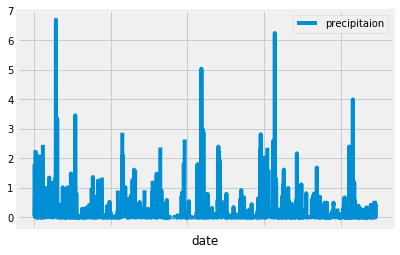

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
prepsort_df.plot(x_compat=True)

plt.savefig("Images/HW_yeardata.png")
plt.show()

In [15]:
prepsort_df.describe()

,precipitaion
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


#### Station Analysis

In [16]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(Station.station)).scalar()
print(station_count)

9


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
engine.execute("SELECT station, COUNT(station) from Measurement GROUP BY station ORDER BY COUNT(station) desc").fetchall()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
engine.execute("SELECT MIN(tobs), MAX(tobs), AVG(tobs) FROM Measurement WHERE station = 'USC00519281'").fetchall()

[(54.0, 85.0, 71.66378066378067)]

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tempyr_data = session.query(Measurement.tobs).\
                    filter(Measurement.station=="USC00519281", Measurement.date >= prev_year).\
                    all()
#print(tempyr_data)

In [20]:
tempyr_df = pd.DataFrame(tempyr_data, columns=["Temps"])
#tempyr_df.head()

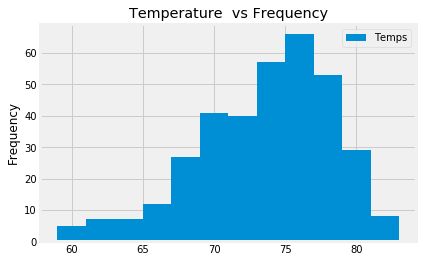

In [21]:
tempyr_df.plot.hist(by="Temps", bins=12,title="Temperature  vs Frequency" )
plt.savefig("Images/HW_Temperature-vs-Frequency.png")
plt.show()

#### Temperature Analysis

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

#Function with travel dates 5-10-2017 through 5-20-2017

print(calc_temps('2017-05-10', '2017-05-20'))

[(68.0, 74.91803278688525, 79.0)]


In [23]:
#Display the temperatures for the trip dated 5-10-2017 through 5-20-2017
start_date = '2017-05-10'
end_date = '2017-05-20'

trip_temps=session.query(Measurement.date, Measurement.tobs).\
                filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
                all()

trip_temp_df = pd.DataFrame(trip_temps, columns=['Date','Temps'])
trip_temp_df.head(5)

,Date,Temps
0,2017-05-10,78.0
1,2017-05-11,78.0
2,2017-05-12,79.0
3,2017-05-13,79.0
4,2017-05-14,77.0


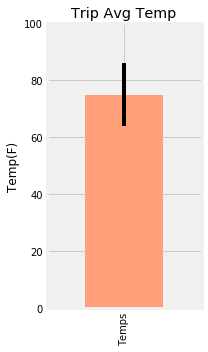

In [25]:
#Calculate the ave and difference in the min/max of the trip temperatures
trip_temp_ave=trip_temp_df.mean()
trip_temp_err=(trip_temp_df['Temps'].max() - trip_temp_df['Temps'].min())

#Plot the results

fig, ax = plt.subplots()

trip_temp_ave.plot.bar(yerr=trip_temp_err, color="lightsalmon", figsize=(3,5))
plt.title("Trip Avg Temp")
plt.ylabel("Temp(F)")
plt.ylim(0,100)
plt.tight_layout()

plt.savefig("Images/HW_bar_plot_with_error_bars.png")

plt.show()